In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import scipy
import scipy.stats as stats
from scipy.stats import norm

##Exercise I - Monte Carlo

In [2]:
def BS_Put(S, K, r, vol, tau):
    
    #BS for European Put Option

    d1 = (np.log(S / K) + (r + ((vol**2)/2.)*tau)) / (vol*np.sqrt(tau))
    d2 = d1 - vol*np.sqrt(tau)
                          
    V = -S * norm.cdf(-d1) + np.exp(-r * tau) * K * norm.cdf(-d2)
    
    return V

In [3]:
def European_Put(T, K, r, S, sigma, trials):

    #calculate the value of a European Put Option
    
    S_T = S * np.exp(r - (0.5 * sigma**2)*T)
    payoff = np.zeros(trials)

    for i in range(trials):
        S_cur = S_T * np.exp(sigma*np.sqrt(T)*np.random.normal())
        
        if K-S_cur > 0:
            payoff[i] = (K-S_cur)*np.exp(-r*T)
        else:
            payoff[i] = 0
        
    return payoff

In [4]:
T = 1
K = 99
r = 0.06
S = 100
sigma = 0.2
trial = 1000000

first_trial = European_Put(T, K, r, S, sigma, trial)

print(f"The European Put's Value is {np.mean(first_trial):.3f} +/- {np.std(first_trial) / np.sqrt(np.size(first_trial)):.3f}")

The European Put's Value is 4.768 +/- 0.008


In [5]:
t = 0
tau = T - t
BS_validation = BS_Put(S, K, r, sigma, tau)
print(f"The Black - Scholes Put Value: {BS_validation:.3f}")

The Black - Scholes Put Value: 4.779


In [6]:
convergence_study = [European_Put(T,K,r,S,sigma,10**i) for i in range(7)]

In [7]:
x= []
y = []
err = []


for i in range(len(convergence_study)):
    x.append(len(convergence_study[i]))
    y.append(np.mean(convergence_study[i]))
    err.append((np.std(convergence_study[i])/np.sqrt(x[i])))

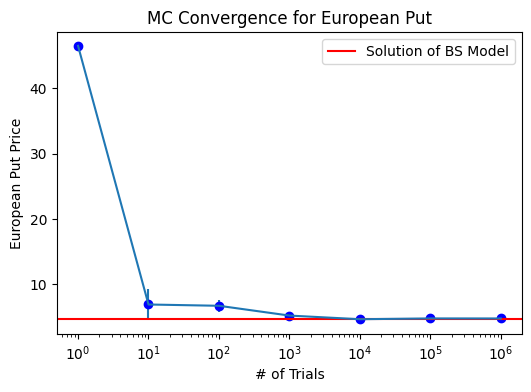

In [8]:
plt.figure(dpi = 100)
plt.errorbar(x, y, err)
plt.plot(x, y, 'bo')
plt.xscale('log')
plt.xlabel("# of Trials")
plt.ylabel("European Put Price")
plt.axhline(y=4.779, color = 'r', label = 'Solution of BS Model')
plt.legend()
plt.title("MC Convergence for European Put")
plt.savefig('MC Convergence for European Put.svg', bbox_inches = 'tight')
plt.show()

In [9]:
# experiment with strike and volatility values

sigma_values = np.linspace(0.1, 2, 20)
K_values = np.linspace(1, 200, 10)

In [10]:
results_sigma_values = [European_Put(T, K, r, S, i, 100000) for i in sigma_values]
results_K_values = [European_Put(T, i, r, S, sigma, 100000) for i in K_values]

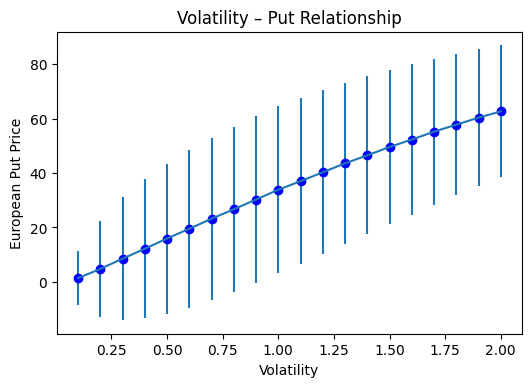

In [11]:
y2 = []
x2 = sigma_values
err2 = []

for i in range(len(results_sigma_values)):
    y2.append(np.mean(results_sigma_values[i]))
    err2.append((np.std(results_sigma_values[i])/np.sqrt(x2[i])))

plt.figure(dpi = 100)
plt.errorbar(x2, y2, err2)
plt.plot(x2, y2, 'bo')
plt.xlabel("Volatility")
plt.ylabel("European Put Price")
plt.title("Volatility – Put Relationship")
plt.savefig('Volatility – Put Relationship.svg', bbox_inches = 'tight')
plt.show()

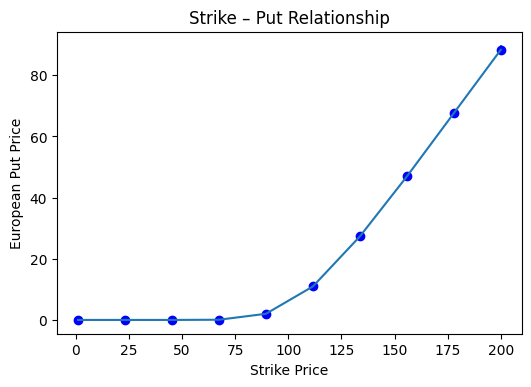

In [12]:
x3 = K_values
y3 = []
err3 = []


for i in range(len(results_K_values)):
    y3.append(np.mean(results_K_values[i]))
    err3.append((np.std(results_K_values[i])/np.sqrt(x3[i])))

plt.figure(dpi = 100)
plt.errorbar(x3, y3, err3)
plt.plot(x3, y3, 'bo')
plt.xlabel("Strike Price")
plt.ylabel("European Put Price")
plt.title("Strike – Put Relationship")
plt.savefig('Strike – Put Relationship.svg', bbox_inches = 'tight')
plt.show()


Tendentially, Monte Carlo has the drawback that large amounts of sampling is needed to receive accurate resutls

##Exercise II - Sensitivity of MC

(1)
We want to compare delta in the MC depending on different seeds for the bumped and unbumped estimate of the value, and then using the same, comparing the two approaches. We expect a better result that actually converges to the true delta as N goes to infitity for using the same seed. This is due to a maximal covariance of 1 and there a variance reduction.

In [13]:
#Define variables
T = 1
K = 99
r = 0.06
S_0 = 100
sigma = 0.2

In [14]:
def cdf_of_d1(S, K, r, sigma, tau):
    
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

    return norm.cdf(d1)


def cdf_of_d2():

    d2 = (np.log(S/K) + (r - 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))

    return norm.cdf(d2) * np.exp(-r*tau)

In [15]:
# Monte Carlo but with mean payoff array

def European_Put(T, K, r, S, sigma, Z, trials):

    #calculate the value of a European Put Option
    
    S_T = S * np.exp(r - (0.5 * sigma**2)*T) * np.exp(sigma*np.sqrt(T)*Z)
    payoff = np.zeros(trials)
    
    for i in range(trials):
        
        if K - S_T[i] > 0:
            payoff[i] = (K-S_T[i])*np.exp(-r*T)
        else:
            payoff[i] = 0

    return np.mean(payoff)

#Test payoff
Z_test = np.random.normal(0,1,100000)
print(European_Put(T, K, r, S, sigma, Z_test, 100000))

4.776955048541118


In [16]:
#Seeds for bumped and unbumped
N = 100000

np.random.seed(N)
Z_1 = np.random.normal(0,1,N)

np.random.seed(N+1)
Z_2 = np.random.normal(0,1,N)

In [17]:
# Approximate delta with MC
eps = 0.5 #far above machine precision, lecture suggests values between 0.01 and 0.5

S_T = S_0 * np.exp((r - 0.5*sigma**2)*T + sigma*m.sqrt(T)*Z_1)
  
S_eps1 = (S_0+eps) * np.exp( (r - 0.5*sigma**2)*T + sigma*m.sqrt(T)*Z_1) #same seed as S
S_eps2 = (S_0+eps) * np.exp( (r - 0.5*sigma**2)*T + sigma*m.sqrt(T)*Z_2) #different side to S

V = European_Put(T, K, r, S_T, sigma, Z_1, N)     #It seem to have an issue with the function European_Put
V_eps1 = European_Put(T, K, r, S_eps1, sigma, Z_1, N)
V_eps2 = European_Put(T, K, r, S_eps2, sigma, Z_2, N)

delta_1 = (V_eps1 - V)/eps #bumped estimate, same seed
delta_2 = (V_eps2 - V)/eps #bumped estimate, different seed

#Print out deltas. We see the approach where the bumped and unbumped method have the same seed, converges. Make a graph here
print(np.norm.cdf(delta_1, delta_2)

SyntaxError: ignored

We compare these estimates of delta with our result from the binomial approximation and the BS analytical results for delta. We can see that seeding bumped and unbumped values identically gives a better proxy, and is converging. Insert graph

(2) Consider an option paying 1€ if the stock at T is higher than the strike, else nothing. Calculate the delta  using method in (1). Use pathwise and likelihood ratio methods with the application of smoothing if necessary, to improve your results. \
We saw that using the same seed comes with more accuracy and a convergence of the estimate. We will use this as the starting point for our sophisticated improvement methods

In [ ]:
#Digital Option function
def dig_option(S_T,K):
  payoff = np.zeros(len(S_T))
  payoff[S_T>K] = 1
  payoff[S_T<=K] = 0
  return payoff

In [ ]:
#Check option payoff
S = S_0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z_1)
K = 99

print(dig_option(S,K))

In [ ]:
# "Pathwise method" differentiation to find delta, smoothen if necessary

np.random.seed (np.random.randint (10 ,10000))
N = 100000
sigma = 0.2
Z_1 = np.random.normal(0,1,N)
S_T = S_0 * np.exp((sigma*m.sqrt(T)*Z_1) + (r - 0.5*sigma**2)*T)


#The digital option is essentially an indicator function with jump at K, and hence the derivative in K does not exist. We approximate the option payoff with a smooth function: A normal-cdf with very small variance is a good candidate
#We instead use a sigmoid here to approximate the indicator function. The larger a, the close to the indicator function
def sigmoid(K, x, a): 
  result =  1/(1+np.exp(a*(-x + K)))
  return result

#Derivative of our indicator proxy w.r.t. the underlying x, a is the degree of convergence to indicator function
def d_sigmoid(K,x, a):
  result = a * sigmoid(K,x, a) * (1-sigmoid(K,x,a))
  return result

dig_option_diff = d_sigmoid(K, S_T, 10)

delta_path = np.exp(-r*T) * dig_option_diff* S_T/S_0 #not sure if S_T is needed
    
#Test
print(np.average(delta_path))

In [ ]:
# "Likelihood method" differentiation to find delta, smoothen if necessary
np.random.seed(np.random.randint (10 ,10000))
Z_1 = np.random.normal(0,1,10000)

S_T = S_0 * np.exp((r - 0.5*sigma**2)*T + sigma*m.sqrt(T)*Z_1)
delta_like = np.zeros(len(S_T))

for i in range(len(S_T)):
  if S_T[i] > K:
    delta_like[i]= np.exp(-r*T)*(Z_1[i]/(S_0*sigma*np.sqrt(T)))
  else:
    delta_like[i]=0

print(np.average(delta_like)) 

##Exercise III - Variance reduction 
Write a program for the price of an Asian option based on geometric averages using the
analytical expression derived in A. Compare the values you obtain with the analytical
expression to those obtained by using Monte-Carlo simulations.

Note for III (3) Combine average & stock price polynomials for Exercise II to get a better approximation, two explanatory variables are necessary

In [ ]:
#(1) Price of the asian call option based on geometric mean
def Price_Asian_C(S_0, T, K, r, sigma, N):

  sigma_tilde = sigma*m.sqrt((2*N+1)/(6*(N+1)))
  r_tilde = 0.5*(r - 0.5*sigma**2 + sigma_tilde)
  d_1_tilde = (np.log(S_0/K) + (r_tilde + 0.5*sigma_tilde**2)*T)/(m.sqrt(T)*sigma_tilde)
  d_2_tilde = (np.log(S_0/K) + (r_tilde - 0.5*sigma_tilde**2)*T)/(m.sqrt(T)*sigma_tilde)
  price = m.exp(-r*T) * (S_0*np.exp(r_tilde*T)*norm.cdf(d_1_tilde) - K*norm.cdf(d_2_tilde))
  
  return price

In [ ]:
#Check option price

T = 1
K = 99
r = 0.06
S_0 = 100
sigma = 0.2
N = 100000

print(Price_Asian_C(S_0, T, K, r, sigma, N))

In [ ]:
#Compare this result with MC

(2) Explain why this works as a control variate (to do)

(3) Apply the control variates technique for the calculation of the value of the Asian option based on arithmetic averages. Study the performance of this technique for different parameter settings (number of paths, strike, number of time points used in the average etc.) \\
The Control Variate is a quasi-MC approximation of the price of the option

In [ ]:
# Control Variate: We have the asian option as our derivative to estimate, and the geometric mean as our control variate

rho = 0.99  #taken from lecture notes
var_red = rho-beta*sigma_tilde/(2*sigma) #check if variance reduction happens, it does since var_red = 0.495
sigma_tilde = sigma*np.sqrt((2*N+1)/(6*(N+1)))
beta = rho * sigma/sigma_tilde
var_red = rho-beta*sigma_tilde/(2*sigma)
S_T = S_0 * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*Z_1)
Geo_mean = np.prod(S_T**(1/(N+1))) #works

C_B = Price_Asian_C(S_0, T, K, r, sigma, N)   #accurate value of geometric mean option
C_B_head = max(Geo_mean - K,0)  #MC approximation of geometric mean option
C_A_head = max(np.average(S_T)-K,0)   #MC approximation of Asian option 
C_A_tilde = C_A_head - beta*(C_B_head - C_B)  #Control variate

print (var_red, C_B_head, C_B, C_A_head, C_A_tilde) #test len(S_T), Geo_mean, 